### Importações

In [2]:
pip install imutils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dense,MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump 
import pickle 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns


### Feature Engineering

In [4]:
def center_content(img):
    h, w = img.shape
    x, y, w, h = cv2.boundingRect(cv2.findNonZero(img))
    centered = np.zeros_like(img)
    offset_x = (centered.shape[1] - w) // 2
    offset_y = (centered.shape[0] - h) // 2
    centered[offset_y:offset_y+h, offset_x:offset_x+w] = img[y:y+h, x:x+w]
    return centered

def correct_skew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

def preprocess_image(img_path):
    # Ler imagem
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
   
    # Correção de Inclinação
    img = correct_skew(img)
    # Centralizar conteúdo
    img = center_content(img)

    return img

In [5]:
# Dados de treino
dir = "./input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"] # Remover os caracteres não alfanuméricos
for i in tqdm (os.listdir(dir)):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1500: # limitador de arquivos
            break
            
        img = preprocess_image(os.path.join(sub_directory,j))
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

100%|██████████| 39/39 [00:32<00:00,  1.20it/s]


In [6]:
len(train_data)

52500

In [7]:
# Dados de validação
val_dir = "./input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in tqdm(os.listdir(val_dir)):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 400: # limitador de arquivos
            break
        img = preprocess_image(os.path.join(sub_directory,j))
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

100%|██████████| 39/39 [00:05<00:00,  7.74it/s]


In [8]:
len(val_data)

10404

In [9]:
# Embaralha nossos valores de treino e teste, para evitar possível vicio na hora do treino
random.shuffle(train_data)
random.shuffle(val_data)

In [10]:
# Separação dos valores dentro do treino entre imagem e label (algo como, imagem e resposta)
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [11]:
# Repetindo a mesma ação anterior mas agora para valiadção
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [12]:
# Aqui a classe LabelBinarizer do sklearn irá transformar as labels (nome do caractere, como quiser chamar) 
# das imagens em um rótulo binário, para que possa ser usado realmente no momento que treinamos nossa rede,
# já que esses valores em string não podem ser usados.
# O LabelBinarizer também será fundamental para traduzirmos o resultado futuramente.
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)


In [13]:
train_X = np.array(train_X)/255.0 # Como os pixels variam de 0 à 255, ao dividir teremos apenas valores no intervalo de 0 a 1
train_X = train_X.reshape(-1,32,32,1) # Remodelamos o vetor para manter a dimensão original (-1) o tamanho de 32x32 e a imagem na escala cinza (1)
train_Y = np.array(train_Y) # Conversão para array numpy

In [14]:
# Mesma coisa citada acima mas com os valores de validação
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [15]:
print(train_X.shape,val_X.shape)

(52500, 32, 32, 1) (10404, 32, 32, 1)


In [16]:
print(train_Y.shape,val_Y.shape)

(52500, 35) (10404, 35)


### Modelo CNN - Convolucional Neural Network  

In [17]:
model = Sequential() # Iniciamos nosso aprendizado de redes neurais sequenciais

# Primeira camada convolucional + pooling
model.add(Conv2D(32, (3, 3), padding="same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Segunda camada convolucional + pooling
model.add(Conv2D(64, (3, 3), activation='softmax'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Terceira camada convolucional + pooling
model.add(Conv2D(128, (3, 3), activation='softmax'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Flatten "achata" a saída de vetor tridimensional das camadas convolucionais 
# e transforma em um vetor de uma dimensão só
model.add(Flatten())

# Graças ao Flattlen, agora é possível aplicar o Dense, que é responsável pela tomada de decisão final
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

# Finalmente, a ultima camada com o total de 35 neurônios, uma para cada classe possível de resultados (0 - 9 e A - Z) 
model.add(Dense(35, activation='softmax'))

C:\Users\rafae\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary() # Verificamos como tudo isso fica junto

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │        17,955 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,283 (1.42 MB)

 Trainable params: 373,283 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Compila
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [20]:
# E rodamos...
history = model.fit(train_X,train_Y, epochs=15, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.3333 - loss: 2.3969 - val_accuracy: 0.7078 - val_loss: 1.4378
Epoch 2/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8335 - loss: 0.5046 - val_accuracy: 0.7290 - val_loss: 1.4390
Epoch 3/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8666 - loss: 0.3950 - val_accuracy: 0.7391 - val_loss: 1.4450
Epoch 4/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8830 - loss: 0.3390 - val_accuracy: 0.7338 - val_loss: 1.4505
Epoch 5/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8911 - loss: 0.3052 - val_accuracy: 0.7623 - val_loss: 1.4258
Epoch 6/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9040 - loss: 0.2658 - val_accuracy: 0.7585 - val_loss: 1.4877
Epoch 7/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9110 - loss: 0.2505 - val_accuracy: 0.7512 - val_loss: 1.4879
Epoch 8/15
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9167 - loss: 0

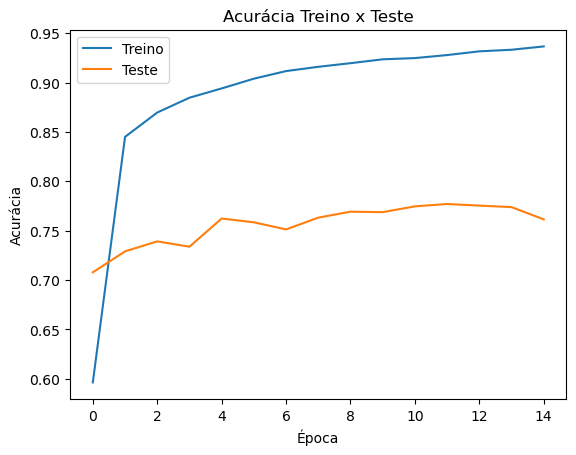

In [21]:
# Plotamos a precisão (acurácia) do treino comparado ao teste (validação)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia Treino x Teste')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

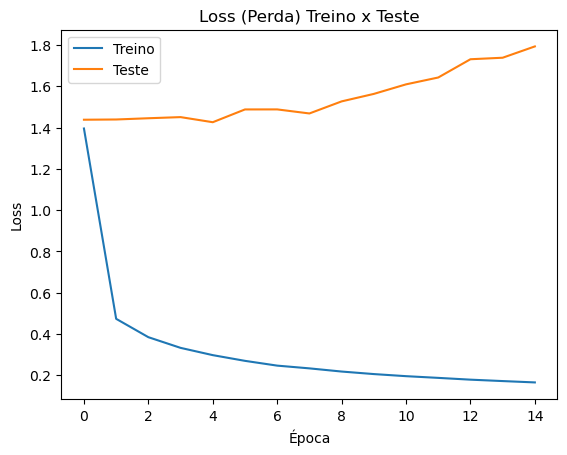

In [22]:
# Plotamos também a perda durante o treino e teste (validação)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss (Perda) Treino x Teste')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

In [23]:
# Pegamos o resultado geral

loss, accuracy = model.evaluate(train_X, train_Y)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

1641/1641 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9551 - loss: 0.1082
Test loss: 0.10827187448740005
Test accuracy: 0.9560381174087524


### Modelo SVM - Support Vector Machine

In [24]:
train_X_flatten = train_X.reshape(train_X.shape[0], -1)
val_X_flatten = val_X.reshape(val_X.shape[0], -1)

# Feature Selection & Feature Engineering com PCA
# Reduzindo a dimensionalidade com PCA para acelerar o processo de treinamento
pca = PCA(n_components=50)  # 50 componentes principais
X_train_pca = pca.fit_transform(train_X_flatten)
X_test_pca = pca.transform(val_X_flatten)

In [25]:
svm_model = SVC()

# Reduzindo o grid de parâmetros
param_grid = {
    'C': [0.1, 1],            # Menos valores para regularização
    'kernel': ['rbf'],         # Usando apenas o kernel RBF
    'gamma': ['scale', 0.001]  # Menos opções para gamma
}

In [26]:
train_Y_svm = LB.inverse_transform(train_Y)
val_Y_svm = LB.inverse_transform(val_Y)

In [27]:
# Utilizando o RandomizedSearchCV para encontrar os melhores hiperparâmetros
random_search = RandomizedSearchCV(svm_model, param_grid, n_iter=4, cv=3, verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train_pca, train_Y_svm)

# Verificando os melhores parâmetros encontrados
print("Melhores parâmetros:", random_search.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Melhores parâmetros: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}


In [28]:
# Treinando o modelo final com os melhores parâmetros encontrados
best_svm = random_search.best_estimator_

y_pred = best_svm.predict(X_test_pca)
print("Classification Report:\n", classification_report(val_Y_svm, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87       368
           1       0.75      0.64      0.69       400
           2       0.84      0.94      0.89       400
           3       0.89      0.96      0.93       400
           4       0.80      0.94      0.87       400
           5       0.96      0.86      0.91       400
           6       0.67      0.97      0.79       400
           7       0.93      0.97      0.95       190
           8       0.78      0.92      0.84       400
           9       0.71      0.97      0.82       400
           A       0.47      0.34      0.40       392
           B       0.66      0.46      0.54       385
           C       0.65      0.93      0.76       168
           D       0.65      0.50      0.57       322
           E       0.86      0.77      0.81       308
           F       0.81      0.85      0.83       324
           G       0.87      0.40      0.55       363
   

### Modelo LR - Logistc Regression

In [29]:
train_X_flatten = train_X.reshape(train_X.shape[0], -1)
val_X_flatten = val_X.reshape(val_X.shape[0], -1)

# Feature Selection & Feature Engineering com PCA
# Reduzindo a dimensionalidade com PCA para acelerar o processo de treinamento
pca = PCA(n_components=50)  # 50 componentes principais
X_train_pca = pca.fit_transform(train_X_flatten)
X_test_pca = pca.transform(val_X_flatten)

In [30]:
train_Y_lr = LB.inverse_transform(train_Y)
val_Y_lr = LB.inverse_transform(val_Y)

In [31]:
print(train_Y_lr)

['0' 'T' '7' ... '7' 'P' 'A']


In [ ]:
# Criando o modelo de Regressão Logística Multiclasse
logistic_model = LogisticRegression(multi_class='multinomial', max_iter=200)

param_grid = {
    'C': [0.1, 1, 10],         # Valores de regularização
    'solver': ['lbfgs', 'saga'] # Solvers compatíveis com regressão multinomial
}

# Utilizando o RandomizedSearchCV para encontrar os melhores hiperparâmetros
random_search = RandomizedSearchCV(
    logistic_model,
    param_distributions=param_grid,
    n_iter=4,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_pca, train_Y_lr)  # Usando X_train_pca e train_Y_lr aqui



In [38]:
# Verificando os melhores parâmetros encontrados
print("Melhores parâmetros:", random_search.best_params_)

# Modelo otimizado
best_logistic = random_search.best_estimator_

# Fazendo previsões no conjunto de validação
y_pred = best_logistic.predict(X_test_pca)  # Usando X_test_pca para validação

# Avaliando o desempenho do modelo
accuracy = accuracy_score(val_Y_lr, y_pred)
print(f"Acurácia: {accuracy * 100:.2f}%")

# Relatório de classificação detalhado
print("\nRelatório de Classificação:")
print(classification_report(val_Y_lr, y_pred))

Melhores parâmetros: {'solver': 'saga', 'C': 10}
Acurácia: 60.66%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.79      0.62      0.70       368
           1       0.69      0.60      0.65       400
           2       0.74      0.81      0.77       400
           3       0.85      0.88      0.87       400
           4       0.69      0.71      0.70       400
           5       0.86      0.71      0.78       400
           6       0.59      0.89      0.71       400
           7       0.82      0.95      0.88       190
           8       0.76      0.76      0.76       400
           9       0.69      0.89      0.78       400
           A       0.40      0.29      0.33       392
           B       0.53      0.35      0.42       385
           C       0.59      0.76      0.66       168
           D       0.57      0.39      0.46       322
           E       0.62      0.60      0.61       308
           F       0.66      0.58      0

### Funções de Captura e Contorno das Letras 

In [33]:
# Essa função usa a lib cv2 (open-cv) para criar o contorno em volta de cada letra em uma palavra
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

In [ ]:
def get_letters(img, model, LB, model_type="cnn", pca=None):
    """
    Função para processar uma imagem e realizar a classificação de caracteres.
    
    Parâmetros:
        img (str): Caminho para a imagem de entrada.
        model: Modelo de classificação (CNN, SVM ou Regressão Logística).
        LB: LabelBinarizer para decodificar as predições.
        model_type (str): Tipo de modelo ('cnn', 'svm', 'lr').
        pca: Modelo PCA para redução de dimensionalidade (necessário para SVM e LR).
        
    Retorna:
        letters (list): Lista de caracteres classificados.
        image: Imagem processada com contornos.
    """
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    # Encontrar contornos
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]

    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            roi = gray[y:y + h, x:x + w]

            # Pré-processamento comum
            roi = correct_skew(roi)
            roi = center_content(roi)
            thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            thresh = cv2.resize(thresh, (32, 32), interpolation=cv2.INTER_CUBIC)
            thresh = thresh.astype("float32") / 255.0

            if model_type == "cnn":
                # Pré-processamento para CNN
                thresh = np.expand_dims(thresh, axis=-1)
                thresh = thresh.reshape(1, 32, 32, 1)
                ypred = model.predict(thresh)
                ypred = LB.inverse_transform(ypred)
                [x] = ypred
                letters.append(x)

            elif model_type in ["svm", "lr"]:
                # Achatar e aplicar PCA, se disponível
                thresh_flatten = thresh.flatten().reshape(1, -1)
                if pca:
                    thresh_flatten = pca.transform(thresh_flatten)
                ypred = model.predict(thresh_flatten)
                letters.append(ypred[0])

    return letters, image

In [40]:
# Esta função junta todas as letras reconhecidas para formar a palavra
def get_word(letter):
    word = "".join(letter)
    return word

### Testes

#### Testes com CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
WKHWV


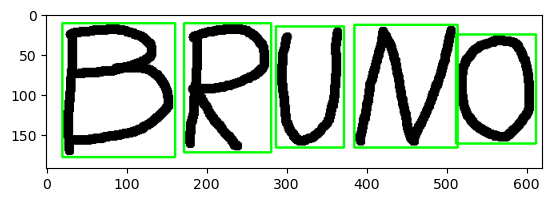

In [49]:
letter, image = get_letters("./testes/teste_bruno.png", model, LB)
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
KAFAFT


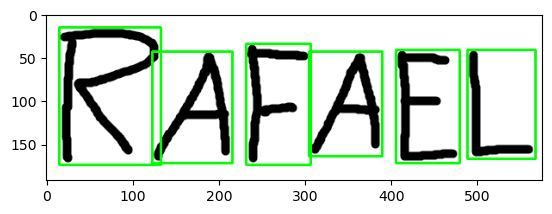

In [50]:
letter, image = get_letters("./testes/teste_rafael.png", model, LB)
word = get_word(letter)
print(word)
plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
YAGN


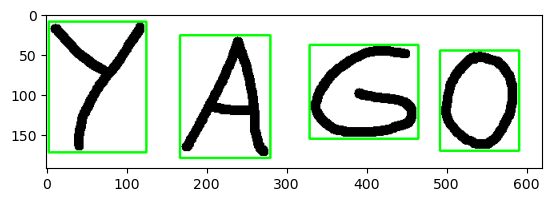

In [51]:
letter, image = get_letters("./testes/teste_yago.png", model, LB)
word = get_word(letter)
print(word)
plt.imshow(image)

#### Testes com SVM

PY7WD


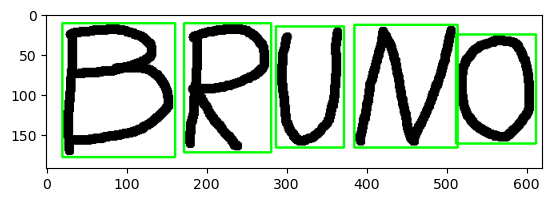

In [53]:
letter, image = get_letters("./testes/teste_bruno.png", best_svm, None, 'svm', pca)
word = get_word(letter)
print(word)
plt.imshow(image)

KAFAFT


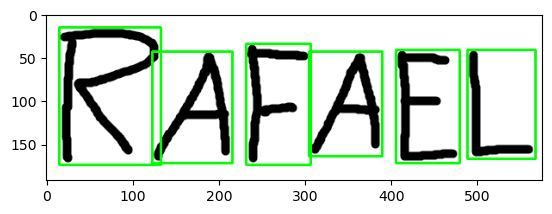

In [54]:
letter, image = get_letters("./testes/teste_rafael.png", best_svm, None, 'svm', pca)
word = get_word(letter)
print(word)
plt.imshow(image)

YFGU


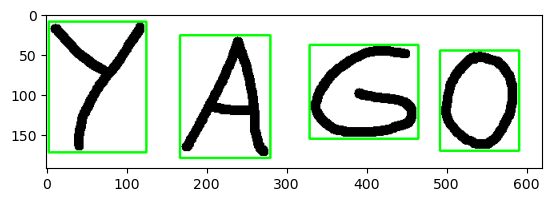

In [55]:
letter, image = get_letters("./testes/teste_yago.png", best_svm, None, 'svm', pca)
word = get_word(letter)
print(word)
plt.imshow(image)

#### Testes com LR

TP4KW


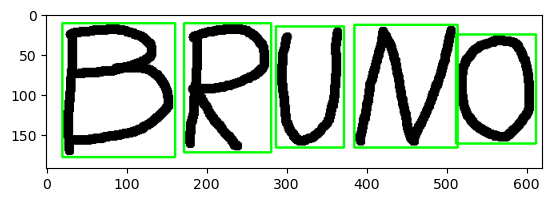

In [48]:
letter, image = get_letters("./testes/teste_bruno.png", best_logistic, None, 'lr', pca)
word = get_word(letter)
print(word)
plt.imshow(image)

YS4S4T


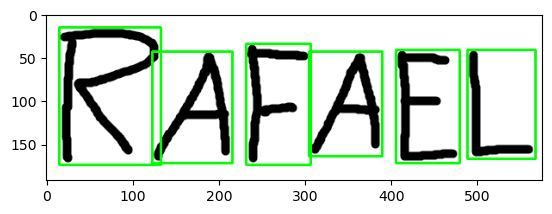

In [ ]:
letter, image = get_letters("./testes/teste_rafael.png", best_logistic, None, 'lr', pca)
word = get_word(letter)
print(word)
plt.imshow(image)

1IFK


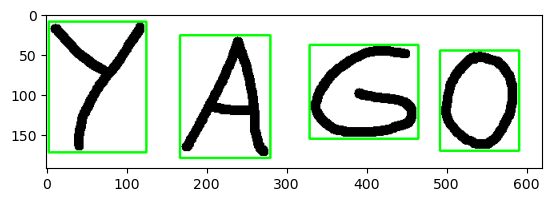

In [ ]:
letter, image = get_letters("./testes/teste_yago.png", best_logistic, None, 'lr', pca)
word = get_word(letter)
print(word)
plt.imshow(image)

### Exportação

In [58]:
import joblib

model.save('./server/model.keras')
joblib.dump(LB,'./server/lb.pkl')
joblib.dump(best_logistic,'./server/logistic.pkl')
joblib.dump(best_svm,'./server/svm.pkl')
joblib.dump(pca,'./server/pca.pkl')

['./server/pca.pkl']